In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, log_loss
from sklearn.metrics import roc_auc_score, plot_roc_curve, average_precision_score

In [10]:
# Set parameters
df = "/data_lab_MT/Ines/Tanaka/BoneRegeneration/CNNC_cluster2_network/20230127_gene_pairs.txt"
pred = "/data_lab_MT/Ines/Tanaka/BoneRegeneration/CNNC_cluster2_network/20230129_BL8-11_2label_FilteredGenes_model/end_y_predict.npy"
start = 0
end = 44424

In [11]:
# Load predicted probabilities of interaction
pred = np.load(file = pred)

prob_list = list(pred)
len(prob_list)
pred_list = []

# Transform the probs into a binary list
for i in range(0, len(prob_list)):
    if prob_list[i][0] > 0.5:
        pred_list.append(1)
    else:
        pred_list.append(0)
prob_list
len(pred_list)

44424

In [12]:
# Load gene pair names and true labels (if available)
true_labels = True
df = pd.read_csv(df, sep = '\t', header = None)

if true_labels == True:
    df.columns = ['From', 'To', 'True_Label']
else:
    df.columns = ['From', 'To']
    
df = df.iloc[start:end, :]
df = df[df.True_Label != 2]
len(df)

44424

In [13]:
# Check that dimensions match
len(pred_list) == len(prob_list) == df.shape[0]

True

In [14]:
# Add the predictions to the df
df['Pred_Label'] = pred_list
df['Prob_Label'] = [item for sublist in prob_list for item in sublist]

df

,From,To,True_Label,Pred_Label,Prob_Label
0,AMEX60DD023580,AMEX60DD000048,1,1,0.530701
1,AMEX60DD000053,AMEX60DD023580,1,1,0.564786
2,AMEX60DD000075,AMEX60DD023580,1,0,0.149880
3,AMEX60DD023580,AMEX60DD000084,1,0,0.467220
4,AMEX60DD023580,AMEX60DD000104,1,0,0.240238
...,...,...,...,...,...
44419,AMEX60DD038107,AMEX60DD017439,0,0,0.164242
44420,AMEX60DD048542,AMEX60DD038107,0,1,0.525761
44421,AMEX60DD038107,AMEX60DD044515,0,1,0.513050
44422,AMEX60DD038107,AMEX60DD018219,0,1,0.548665


In [15]:
# Save df as a tsv 
filename = '/data_lab_MT/Ines/Tanaka/BoneRegeneration/CNNC_cluster2_network/20230129_BL8-11_2label_FilteredGenes_model/20230129_BL8-11_2labels_filteredGenes_TestPredictionDF.tsv'
df.to_csv(filename, sep = '\t', index=False)

## Calculate model evaluation metrics

In [16]:
# Construct confusion matrix
# The numbers are [TN, FP], [FN, TP]
confMat = confusion_matrix(df['True_Label'], df['Pred_Label'])
confMat

array([[10992, 11220],
       [ 5157, 17055]])

### Precision

We don't mind if the CNNC precision is not great, because we will do further steps for GNRI. It's ok if we have some FPs, as long as we don't make too many FNs.

In [17]:
# TP / TP + FP
Precision = precision_score(df['True_Label'], 
                            df['Pred_Label'])
print('Precision: ', Precision)

Precision:  0.6031830238726791


### Recall (or TPR or sensitivity)

For the CNNC example, we want the recall to be as high as possible because we want to minimize the number of FNs. The reason for this is that, since CNNC will be our first step in GNRI, we don't care so much about having a few FPs that we can later filter, but we want to be sure that we don't miss any real gene interactions.

In [18]:
# TP / P = TP / (TP + FN)
Recall = recall_score(df['True_Label'], df['Pred_Label'])
print('Recall: ', Recall)

Recall:  0.7678282009724473


### Specificity (or TNR or selectivity)

In [19]:
# TN / N
Selectivity = confMat[0,0] / (confMat[0,1] + confMat[0,0])
print('Selectivity: ', Selectivity)

Selectivity:  0.49486763911399245


### FNR (miss) 

Important metric for us because we want to have as little FN as possible. It should be as close to 1 as possible.

In [20]:
# FN / P
FNR = confMat[1,0] / (confMat[1,0] + confMat[1,1])
print('FNR:', FNR)

FNR: 0.23217179902755267


 ### Accuracy
 
 Not the best metric for CNNC performance evaluation because, although the data set is balanced, the model outputs probabilities.

In [21]:
#(TP + TN ) / (TP + TN + FP + FN)
Acc = accuracy_score(df['True_Label'], df['Pred_Label'])
print('Accuracy: ', Acc)

Accuracy:  0.6313479200432199


### F1-score

Function of precision and recall. Good if we want a balance between these two metrics.

In [22]:
#(2 * TP) / (2*TP + FP + FN)
f1 = f1_score(df['True_Label'], df['Pred_Label'])
print('F1-score: ', f1)

F1-score:  0.6756194663972904


### Log-loss

In [23]:
logloss = log_loss(df['True_Label'], df['Pred_Label'])
print('Log-loss: ', logloss)

Log-loss:  12.7329937084148


### AUROC

In [24]:
auroc = roc_auc_score(df['True_Label'], df['Prob_Label'])
print('AUROC: ', auroc)

AUROC:  0.6703395160234


In [25]:
# Plot?

### AUPCR

In [26]:
auprc = average_precision_score(df['True_Label'], df['Prob_Label'])
print('AUPRC: ', auprc)

AUPRC:  0.6330775820093448


## Distribution of the predicted probabilities

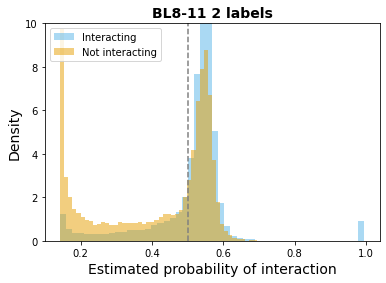

In [27]:
plt.hist(df.loc[df['True_Label'] == 1]['Prob_Label'], density = True, bins = 50, alpha=0.5, label="Interacting",
        color="#56b4e9")
plt.hist(df.loc[df['True_Label'] == 0]['Prob_Label'], density = True, bins = 50, alpha=0.5, 
         label="Not interacting", color = "#e69f00")
plt.ylim([0, 10])
plt.axvline(0.5, color='grey', linestyle='dashed', linewidth=1.5)
plt.xlabel("Estimated probability of interaction", size=14)
plt.ylabel("Density", size=14)
plt.title('BL8-11 2 labels', size = 14, fontweight="bold")
plt.legend(loc='upper left', prop={'size': 10})
plt.savefig('/data_lab_MT/Ines/Tanaka/BoneRegeneration/CNNC_cluster2_network/20230129_BL8-11_2label_FilteredGenes_model/20230129_BL8-11_2labels_filteredGenes_DistributionPredictedProbabilities.png')